The percentage change in the total energy of the system is -0.0030878252240020684%
2K + U at start is -7.648095314004527e+36
2K + U at end is -1.7059416734428306e+36
2K / U at start is -6.833088938025081e-07
2K / U at 2nd timestep (KE=0 at t=0) is -6.150544386294462e-06
2K / U at end is -0.8744775216103621


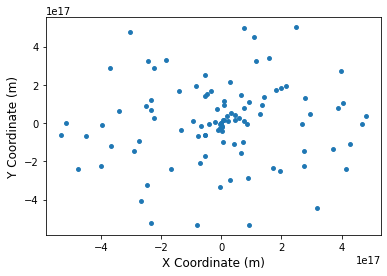

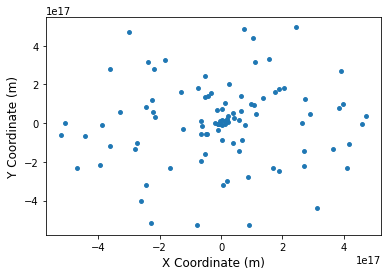

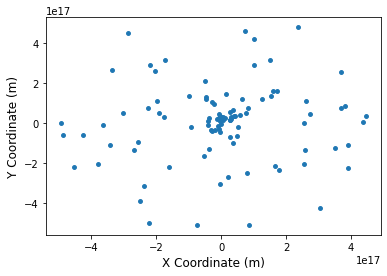

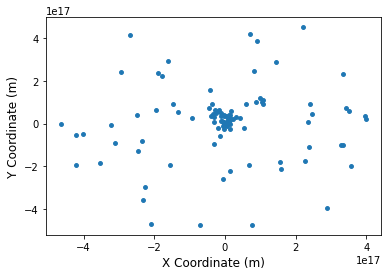

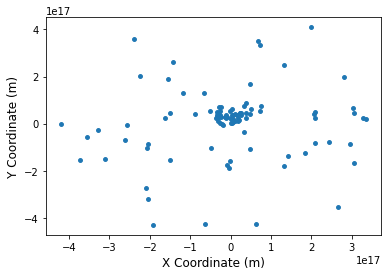

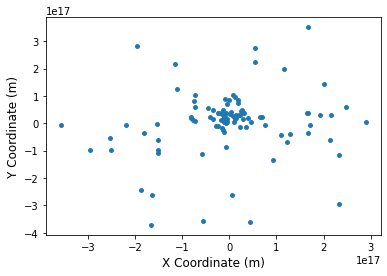

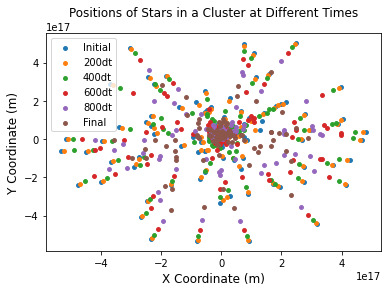

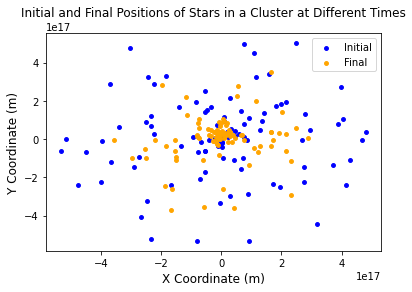

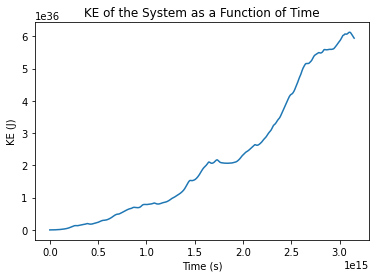

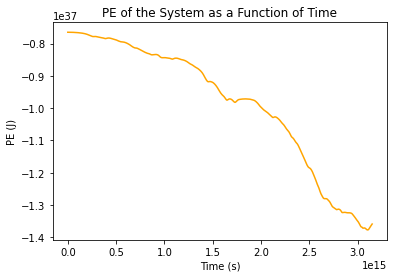

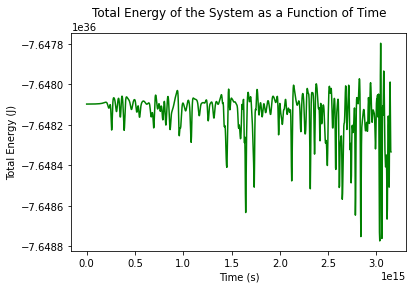

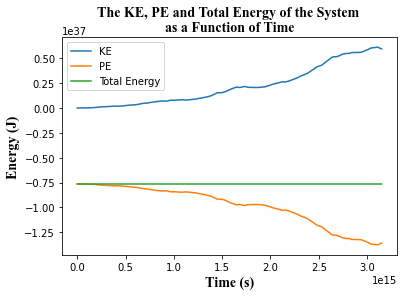

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animate
from numpy.linalg import norm

# constants
G = 6.67 * 10 ** (-11)         # m^3 kg^-1 s^-2
m_sun = 1.9889 * 10 ** 30       # m
pc = 3.09 * 10 ** (16)     # m

n_particles = 100     # number of particles in system
r_sphere = 20 * pc    # radius of sphere that particles start in
s = 0.01 * r_sphere   # softening factor for force
s_squared = s * s
n_timesteps = 1000
dt = 1 * 10 ** 5 * 365 * 24 * 3600     # trial and error until it seemed to progressively collapse
mass = m_sun
#np.ones((n_particles)) * m_sun   # all same so just keep as constant for now
#masses = [1] * n_particles    # all set to have equal mass - can also do np.ones(n) & multiply by whatever mass I want them all to have

dtbymass = dt / mass

forces = np.zeros((n_particles, 3, n_timesteps))
positions = np.zeros((n_particles, 3, n_timesteps))
velocities = np.zeros((n_particles, 3, n_timesteps + 1))
pe_tot = np.zeros((n_timesteps))

# boundaries
# using spherical coords to get higher density of particles near centre as seen in actual globular clusters
for i in range(0, n_particles):
    r = random.random() * r_sphere
    theta = random.random() * np.pi
    phi = random.random() * 2 * np.pi 
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    positions[i,:,0] = [x,y,z]


def grav_force(mass,positions):
    # separation vectors as NxN matrices of comps x,y,z
    rx_mat = positions[:,0:1] - positions[:,0:1].T
    ry_mat = positions[:,1:2] - positions[:,1:2].T
    rz_mat = positions[:,2:3] - positions[:,2:3].T
    #print(rx_mat,"\n",ry_mat,"\n",rz_mat,"\n")
    #then need to convert this from a NxN to a 1XN
    #print(np.shape(rx_mat))
    mod_sq = np.power(rx_mat,2) + np.power(ry_mat,2) + np.power(rz_mat,2)
    r_sq = (mod_sq + s_squared) ** (1.5)
    fx_mat = - G * mass * mass * rx_mat/r_sq
    fy_mat = - G * mass * mass * ry_mat/r_sq
    fz_mat = - G * mass * mass * rz_mat/r_sq
    force_x = np.sum(fx_mat, axis = 1)
    force_y = np.sum(fy_mat, axis = 1)
    force_z = np.sum(fz_mat, axis = 1)
    force = np.array([force_x, force_y, force_z]).T
    return force


def calc_ke(m, v):
    v_sq_comp = np.power(v, 2)
    v_sq = np.sum(v_sq_comp, axis = 1)
    ke = 0.5 * m * v_sq
    return ke


def calc_pe(mass, positions):
    rx_mat = positions[:,0:1] - positions[:,0:1].T
    ry_mat = positions[:,1:2] - positions[:,1:2].T
    rz_mat = positions[:,2:3] - positions[:,2:3].T
    # don't want to double calc so take upper triangular
    # ii element is already zero and want everything below = 0 --> ,1
    #rx_ut = np.triu(rx_mat,1)
    #ry_ut = np.triu(ry_mat,1)
    #rz_ut = np.triu(rz_mat,1)
    #mod_sq = np.power(rx_ut,2) + np.power(ry_ut,2) + np.power(rz_ut,2)
    mod_sq = np.power(rx_mat, 2) + np.power(ry_mat, 2) + np.power(rz_mat, 2)
    r_sq = np.sqrt(mod_sq + s_squared)
    inv_r = 1/r_sq
    pe = - G * mass * mass * np.sum(np.triu(inv_r), axis = 1)
    return pe


# get initial force for loop
forces[:,:,0] = grav_force(mass, positions[:,:,0])

# initial pe
pe = calc_pe(mass, positions[:,:,0])
pe_tot[0] = np.sum(pe, axis = 0)

# main loop
for i in range(0, n_timesteps - 1): 
    velocities[:,:,i+1] = velocities[:,:,i] + forces[:,:,i] * dtbymass
    positions[:,:,i+1] = positions[:,:,i] + velocities[:,:,i+1] * dt
    forces[:,:,i+1] = grav_force(mass, positions[:,:,i+1])

    # calculate pe
    pe = calc_pe(mass, positions[:,:,i+1])
    pe_tot[i+1] = np.sum(pe)


# calc last v at half timestep after last so ke and pe can be shifted
velocities[:,:,n_timesteps] = velocities[:,:,n_timesteps - 1] + forces[:,:,n_timesteps - 1] * dtbymass

# midpooints of vel so at same time as pos
shift_v = velocities[:,:,:-1] + np.diff(velocities) * 0.5

# calculate ke
ke = calc_ke(mass, shift_v)
ke_tot = np.sum(ke,axis=0)


# define total energy
e_tot = ke_tot + pe_tot

# define times to plot against
times = np.arange(0, (n_timesteps) * dt, dt)

markersize = 15

# get some useful values:
e_change_percent = (e_tot[-1] - e_tot[0]) / abs(e_tot[0]) * 100
print(f"The percentage change in the total energy of the system is {e_change_percent}%")

virial0 = 2 * ke_tot[0] + pe_tot[0]
virial_end = 2 * ke_tot[-1] + pe_tot[-1]
print(f'2K + U at start is {virial0}')
print(f'2K + U at end is {virial_end}')

virial_ratio0 = 2 * ke_tot[0] / pe_tot[0]
virial_ratio1 = 2 * ke_tot[1] / pe_tot[1]
virial_ratio_end = 2 * ke_tot[-1] / pe_tot[-1]
print(f'2K / U at start is {virial_ratio0}')
print(f'2K / U at 2nd timestep (KE=0 at t=0) is {virial_ratio1}')
print(f'2K / U at end is {virial_ratio_end}')


# plot data
plt.figure(13)
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
#for i in range(0, n_particles - 1):
plt.scatter(positions[:,0:1:,0],positions[:,1:2:,0], s = markersize)

#plt.figure(figsize = (5,5))
plt.figure(14)
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
#for i in range(0, n_particles - 1):
plt.scatter(positions[:,0:1:,200],positions[:,1:2:,200], s = markersize)

#plt.figure(figsize = (5,5))
plt.figure(15)
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
#for i in range(0, n_particles - 1):
plt.scatter(positions[:,0:1:,400],positions[:,1:2:,400], s = markersize)

#plt.figure(figsize = (5,5))
plt.figure(16)
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
#for i in range(0, n_particles - 1):
plt.scatter(positions[:,0:1:,600],positions[:,1:2:,600], s = markersize)

#plt.figure(figsize = (5,5))
plt.figure(17)
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
#for i in range(0, n_particles - 1):
plt.scatter(positions[:,0:1:,800],positions[:,1:2:,800], s = markersize)

#plt.figure(figsize = (5,5))
plt.figure(18)
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
#for i in range(0, n_particles - 1):
plt.scatter(positions[:,0:1:,-1],positions[:,1:2:,-1], s = markersize)

plt.figure(19)
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
plt.title("Positions of Stars in a Cluster at Different Times")
#for i in range(0, n_particles - 1):
plt.scatter(positions[:,0:1:,0],positions[:,1:2:,0], label = "Initial", s = markersize)
plt.scatter(positions[:,0:1:,200],positions[:,1:2:,200], label = "200dt", s = markersize)
plt.scatter(positions[:,0:1:,400],positions[:,1:2:,400], label = "400dt", s = markersize)
plt.scatter(positions[:,0:1:,600],positions[:,1:2:,600], label = "600dt", s = markersize)
plt.scatter(positions[:,0:1:,800],positions[:,1:2:,800], label = "800dt", s = markersize)
plt.scatter(positions[:,0:1:,-1],positions[:,1:2:,-1], label = "Final", s = markersize)
plt.legend()
plt.savefig("Positions of Stars in a Cluster at Different Times.png", bbox_inches = 'tight', dpi = 400)

plt.figure(20)
plt.xlabel("X Coordinate (m)", fontsize = 12)
plt.ylabel("Y Coordinate (m)",fontsize = 12)
plt.title("Initial and Final Positions of Stars in a Cluster at Different Times")
#for i in range(0, n_particles - 1):
plt.scatter(positions[:,0:1:,0],positions[:,1:2:,0], label = "Initial", s = markersize, color = 'blue')
plt.scatter(positions[:,0:1:,-1],positions[:,1:2:,-1], label = "Final", s = markersize, color = 'orange')
plt.legend()
plt.savefig("Initial and Final Positions of Stars in a Cluster at Different Times.png", bbox_inches = 'tight', dpi = 400)

plt.figure(21)
plt.plot(times, ke_tot)
plt.title("KE of the System as a Function of Time")
plt.xlabel("Time (s)")
plt.ylabel("KE (J)")

plt.figure(22)
plt.plot(times, pe_tot, color = 'orange')
plt.title("PE of the System as a Function of Time")
plt.xlabel("Time (s)")
plt.ylabel("PE (J)")

plt.figure(23)
plt.plot(times, e_tot, color = 'green')
plt.title("Total Energy of the System as a Function of Time")
plt.xlabel("Time (s)")
plt.ylabel("Total Energy (J)")

plt.figure(24)
plt.plot(times, ke_tot, label = "KE")
plt.plot(times, pe_tot, label = "PE")
plt.plot(times, e_tot, label = "Total Energy")
plt.xlabel("Time (s)", fontsize = 14, fontname="Times New Roman", fontweight = 'bold')
plt.ylabel("Energy (J)",fontsize = 14, fontname="Times New Roman", fontweight = 'bold')
plt.title("The KE, PE and Total Energy of the System \nas a Function of Time", fontsize = 14, fontname="Times New Roman", fontweight = 'bold')

plt.legend()

plt.show()